In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("notebook")

# Coded aperture simulation and image reconstruction

In [2]:
from sympy.ntheory.primetest import isprime
from scipy.signal import correlate

def ura(r, s, m=1):
    assert(isprime(r))
    assert(isprime(s))
    assert(r - s == 2)
    
    C_r_I = np.zeros(r) - 1
    C_s_J = np.zeros(s) - 1
    for x in range(1, r):
        C_r_I[x**2 % r] = 1
    for y in range(1, s):
        C_s_J[y**2 % s] = 1

    A_IJ = np.zeros([r,s])
    for I in range(r):
        for J in range(s):
            if I == 0:
                A_IJ[I,J] = 0
            elif J == 0:
                A_IJ[I,J] = 1
            elif C_r_I[I] * C_s_J[J] == 1:
                A_IJ[I,J] = 1

    A_ij = np.zeros([m*r,m*s])
    for i in range(m*r):
        for j in range(m*s):
            A_ij[i,j] = A_IJ[i%r,j%s]
    A_ij = np.roll(A_ij, int((r+1)/2), axis=0)
    A_ij = np.roll(A_ij, int((s+1)/2), axis=1)
    
    G_ij = A_ij.copy()
    G_ij[G_ij == 0] = -1
    return A_ij, G_ij

def _pad(A):
    ws = [int(dim/2) for dim in A.shape]
    return np.pad(
        A, 
        pad_width= [(int(dim/2), int(dim/2)) for dim in A.shape], 
        mode = "wrap",
    )

def _absorbed(photons, A):
    _A = _pad(A)
    dirx, diry, impx, impy = photons.T
    return _A[dirx + impx, diry + impy] == 0

def transport(photons, A):
    mask_size = A.shape
    transmitted = photons[~_absorbed(photons, A)]
    detector, *_ = np.histogram2d(
        x = transmitted[:, 2],
        y = transmitted[:, 3],
        bins=[
            np.arange(mask_size[0] + 1), 
            np.arange(mask_size[1] + 1)
        ]
    )
    return detector

def transmit(photons, A):
    transmitted = photons[~_absorbed(photons, A)]
    counts, *_ = np.histogram2d(
        x = transmitted[:, 0],
        y = transmitted[:, 1],
        bins=[
            np.arange(mask_size[0] + 1), 
            np.arange(mask_size[1] + 1)
        ]
    )
    return counts

def source(photons, A):
    counts, *_ = np.histogram2d(
        x = photons[:, 0],
        y = photons[:, 1],
        bins=[
            np.arange(mask_size[0] + 1), 
            np.arange(mask_size[1] + 1)
        ]
    )
    return counts

def decode(detector, G):
    n, m = detector.shape
    return correlate(_pad(G), detector)[n-1: -n+1, m-1: -m+1]

def encode(source, A):
    n, m = source.shape
    norm = np.sum(A[A==1])
    detector = correlate(_pad(A), source)[n-1: -n+1, m-1: -m+1] / norm
    return detector

def variance(detector, G):
    n, m = detector.shape
    return correlate(np.square(_pad(G)), detector)[n-1: -n+1, m-1: -m+1]

# The simulation

The simulation idea is:

1. Build the mask. We implement a cyclic URA aperture mask from a sequence with size `n * m`, according the geometry of Gottesman 2007. This implies that the aperture mask will have appropriate padding resulting in a msk with dimension `(2*n - 1, 2*m -1)`.
2. Simulate the background. We sample a number of 4-tuples. The first couple in the tuple represent the photon source's direction. The second couple in the tuple represent the photon "landing pixel" on the coded aperture. Both the photon's direction and landing site are chosen at random. Transmitting photons land on an open elements of the coded aperture. They are propagated through (transported) to the detector. Photons intercepting an opaque mask elements are considered absorbed and are not counted when forming the detector image.
3. Simulate a bright signal from some directions. The procedure of 2. is repeated for `nsignal` photons. However, this time, photons will have their direction fixed a-priori.

The mask we employ is a URA.

In [3]:
mask_size = (61,59)
A, G = ura(*mask_size) 

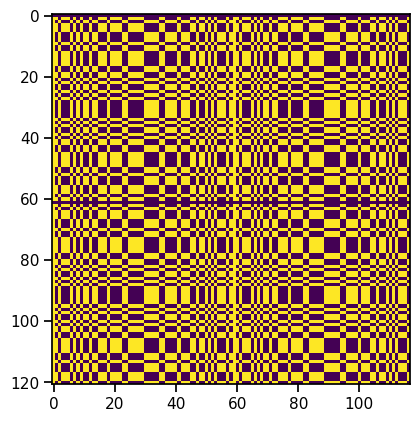

In [4]:
plt.imshow(_pad(A))
plt.show()

We simulate a signal due to multiple point sources and a constant background.

In [5]:
def generate_photons(n: int, A: np.array, direction: np.array):
    mask_size = A.shape
    if type(direction) is str and direction == "random":
        ps = np.dstack(
            (
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
            )
        )[0] 
    else:
        ps = np.dstack(
            (
                *(direction * np.ones((n, 2))).T, 
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
            )
        )[0]
    return ps.astype(int)

In [6]:
background_rate = 1
background_photons = generate_photons(background_rate * np.prod(mask_size), A, "random")

nsignals = np.linspace(666, 666, num=5, dtype=int)
signal_dirs = np.dstack([
    np.random.randint(mask_size[0], size=len(nsignals)),
    np.random.randint(mask_size[1], size=len(nsignals)),
])[0]
signal_photons = np.concatenate(
    [
        generate_photons(nsignal, A, signal_dir) 
        for (nsignal, signal_dir) in zip(nsignals, signal_dirs)
    ]
)

photons = np.concatenate((background_photons, signal_photons))

The source emission, unmodulated by the coded aperture is:

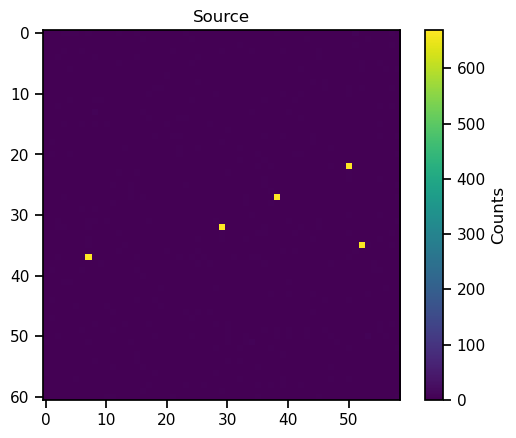

In [7]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(source(photons, A))
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Source")
plt.show()

Now we count photons transmitted over the coded aperture and compute the detector's counts

In [8]:
transmitted = transmit(photons, A)
detector = transport(photons, A)

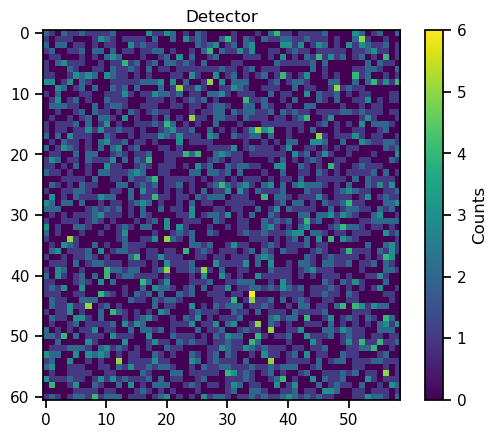

In [9]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

# Image reconstruction by cross correlation

In [10]:
decoded = decode(detector, G)

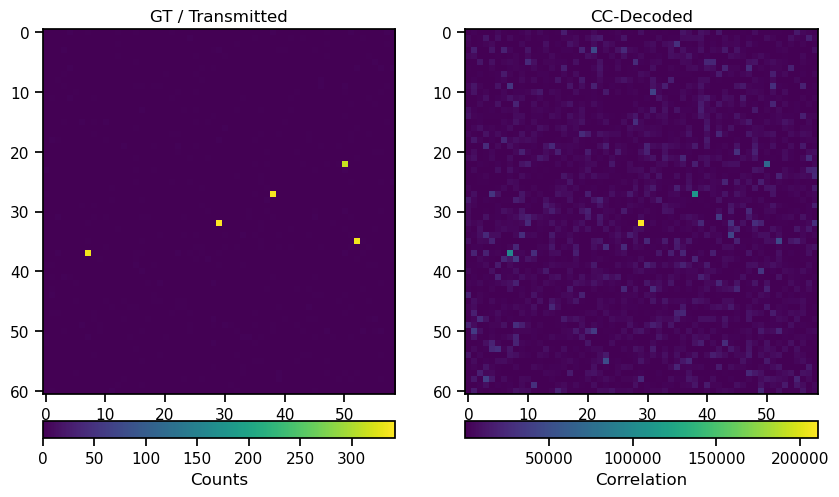

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7) )

c0 = axs[0].imshow(transmitted)
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts", pad=0.05)
axs[0].set_title("GT / Transmitted")

c2 = axs[1].imshow(decoded ** 2)
fig.colorbar(c2, ax=axs[1], location="bottom", label="Correlation", pad=0.05)
axs[1].set_title("CC-Decoded")

plt.show()

# Image reconstruction by MLEM

In [12]:
def mlem_prob(A):
    n, m = A.shape
    p = np.zeros((n , m) * 2)
    for i in range(n):
        for j in range(m):
            p[i, j, :] = _pad(A)[i:i+n, j:j+m]
    p /= np.sum(A)
    return p

In [13]:
def mlem(detector, prob, niters=32):
    n, m = detector.shape
    y0 = np.ones((n, m)) * np.mean(detector)
    y_j = np.zeros((n, m))
    y_i = y0
    for _ in range(niters):
        y_j = y_i * np.sum(
            detector * prob / np.sum(
                y_i * prob, 
                axis=(2, 3),
            )
            , axis = (2, 3),
        )
        y_i = y_j.copy()
    return y_j

In [14]:
niters = 100
mlemrec = mlem(detector, mlem_prob(A), niters)

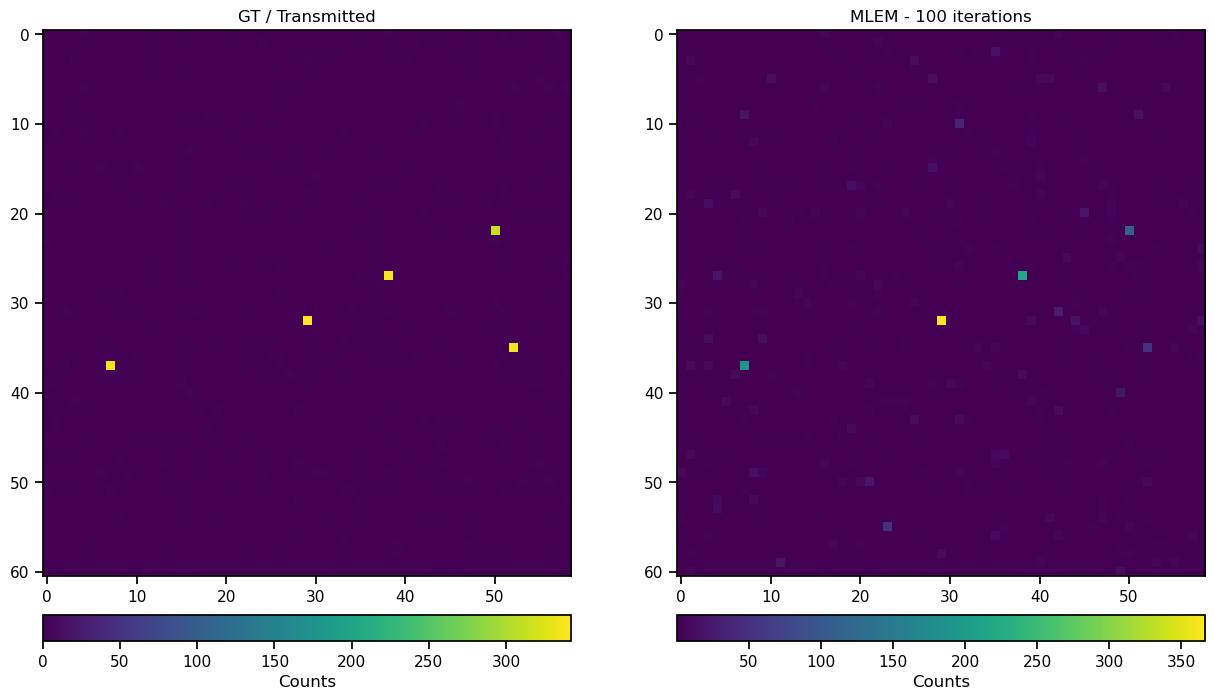

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10) )

c0 = axs[0].imshow(transmitted)
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts", pad=0.05)
axs[0].set_title("GT / Transmitted")

c2 = axs[1].imshow(mlemrec)
fig.colorbar(c2, ax=axs[1], location="bottom", label="Counts", pad=0.05)
axs[1].set_title(f"MLEM - {niters} iterations")

plt.show()

In [1]:
def significance(n, b):
     return np.sqrt(2 * (n * np.log(n / b) - (n - b)))

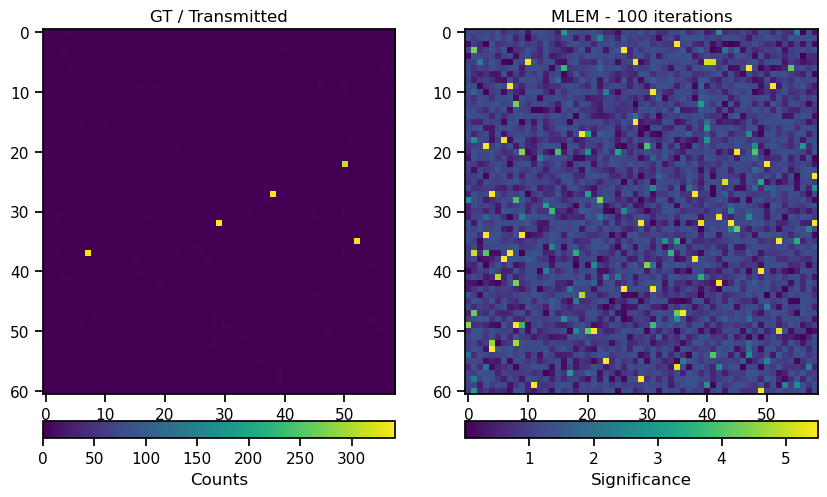

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7) )

c0 = axs[0].imshow(transmitted)
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts", pad=0.05)
axs[0].set_title("GT / Transmitted")

c2 = axs[1].imshow(significance(mlemrec, background_rate), vmax = 5.5)
fig.colorbar(c2, ax=axs[1], location="bottom", label="Significance", pad=0.05,
    norm=mpl.colors.LogNorm(vmin=0, vmax=5),
)
axs[1].set_title(f"MLEM - {niters} iterations")

plt.show()

In [18]:
def mlem(detector, prob, maxiter=100):
    stats = []
    
    n, m = detector.shape
    y_j = np.zeros((n, m))
    y0 = np.ones((n, m)) * np.mean(detector)
    y_i = y0
    for _ in range(maxiter):
        y_j = y_i * np.sum(
            detector * prob / np.sum(
                y_i * prob, 
                axis=(2, 3),
            )
            , axis = (2, 3),
        )
        y_i = y_j.copy()
        fistat = np.sum((y_j - np.median(y_j)) ** 2 / np.median(y_j))
        
        stats.append((y_j.copy(), fistat))
    return stats

In [19]:
stats = mlem(detector, mlem_prob(A))
maps, fitstats = list(zip(*stats))
best_match = np.argmin(np.abs(fitstats - np.prod(mask_size)))
mlemrec = maps[best_match]

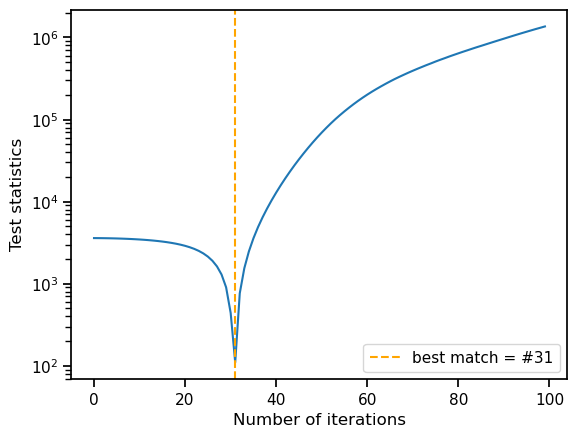

In [20]:
plt.plot(np.abs(fitstats - np.prod(mask_size)))
plt.axvline(best_match, ls="dashed", color="orange", label=f"best match = #{best_match}")
plt.ylabel("Test statistics")
plt.xlabel("Number of iterations")
plt.legend()
plt.semilogy()
plt.show()

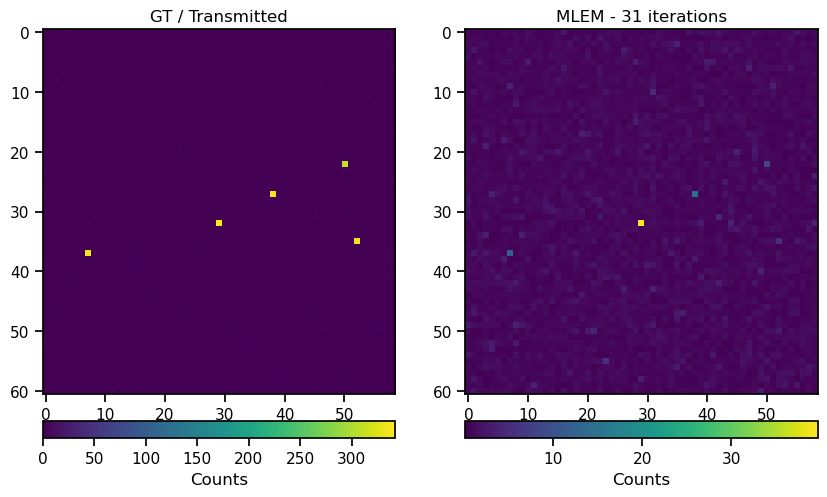

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7) )

c0 = axs[0].imshow(transmitted)
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts", pad=0.05)
axs[0].set_title("GT / Transmitted")

c2 = axs[1].imshow(mlemrec)
fig.colorbar(c2, ax=axs[1], location="bottom", label="Counts", pad=0.05)
axs[1].set_title(f"MLEM - {best_match} iterations")

plt.show()

In [22]:
threshold = 5.
s = significance(mlemrec, background_rate)
x, y = np.argwhere(s > threshold).T

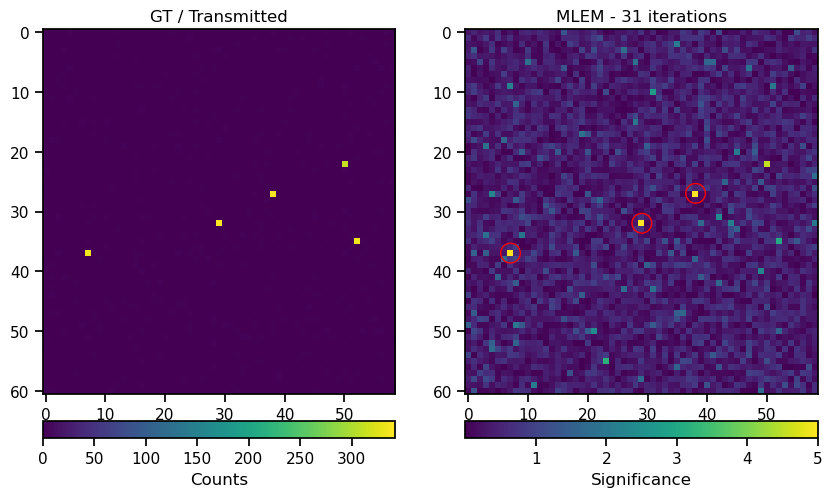

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7) )

c0 = axs[0].imshow(transmitted)
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts", pad=0.05)
axs[0].set_title("GT / Transmitted")

c2 = axs[1].imshow(s, vmax=5)
plt.scatter(y + 0.05, x - 0.05, facecolors='none', edgecolors='r', s= 200, linewidth=1)
fig.colorbar(c2, ax=axs[1], location="bottom", label="Significance", pad=0.05,
    norm=mpl.colors.LogNorm(vmin=0, vmax=5),
)
axs[1].set_title(f"MLEM - {best_match} iterations")

plt.show()